In [57]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

#Using newest versions of all libraries

In [58]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from resnet import ResNet18
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [59]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M10"] #The labels in the hdf5 dataset
PLOT_LABELS = ["SPH_9TeV", "BH_n4_M10"] #For plotting
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH"]
N_EVENTS = [10000, 10000]
CUT=False

#Set data paths
if CUT:
    FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{n}_events.h5" for label, n in zip(LABELS, N_EVENTS)]
else:
    FILENAMES = [f"{label}_res{RES}_{n}_events.h5" for label, n in zip(LABELS, N_EVENTS)]
DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{FILENAMES[i]}" for i in range(CLASSES)]

#Setup GPU if available
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
ampl.use_atlas_style()   
#sn.set_theme(context="notebook", style="white", palette="Paired", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

Running on the GPU


In [60]:
def add_images(data, axis, device):
    dataset = DataLoader(data, 1, shuffle=False)
    image = torch.zeros([50, 50]).to(device)
    for data in tqdm(dataset):
        X, y = data
        event = X[:,:,:,axis].view(50,50)
        image = image + event
    return(image)

In [61]:
#load data in memory
sph_path = [Path(DATAPATHS[0])]
bh_path = [Path(DATAPATHS[1])]
print(sph_path, bh_path)
#Load lazily
sph_data = Hdf5Dataset(sph_path, LABELS, DEVICE, 
                        shuffle=False, filters=None, transform=None)
bh_data = Hdf5Dataset(bh_path, LABELS, DEVICE, 
                        shuffle=False, filters=None, transform=None)

[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_10000_events.h5')] [PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_res50_10000_events.h5')]


In [62]:
all_data = [sph_data, bh_data]
images = np.zeros((CLASSES, 3, 50,50))

for i in range(CLASSES):
    for j in range(3):
        images[i][j] = add_images(all_data[i], j, DEVICE).cpu()

100%|██████████| 10000/10000 [00:08<00:00, 1159.49it/s]


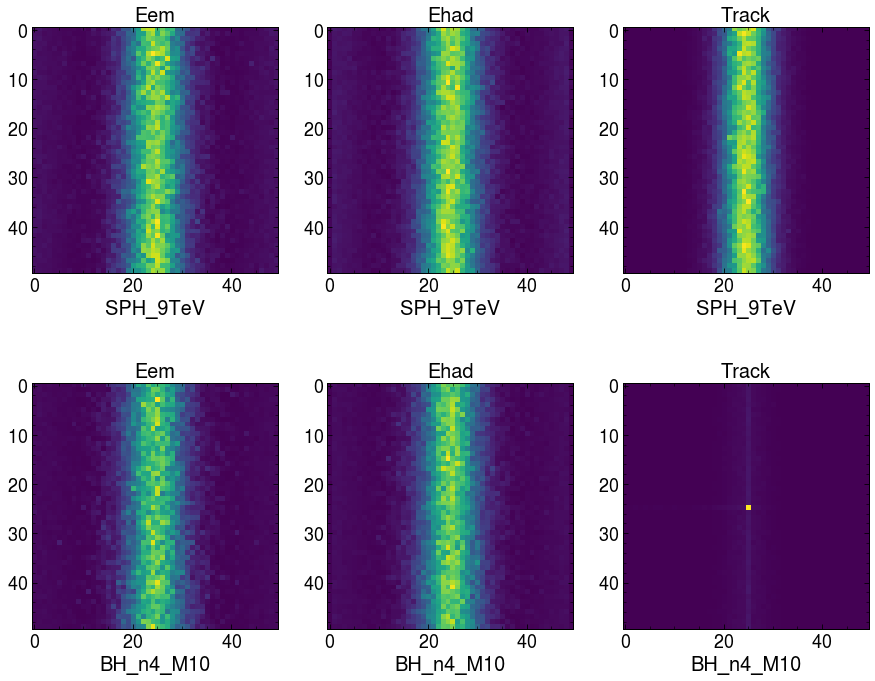

In [71]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 12))
layer_labels = ["Eem", "Ehad", "Track"]
for i in range(CLASSES):
    for j in range(3):
        axs[i][j].imshow(images[i][j])
        axs[i][j].set_xlabel(PLOT_LABELS[i])
        axs[i][j].set_title(layer_labels[j])


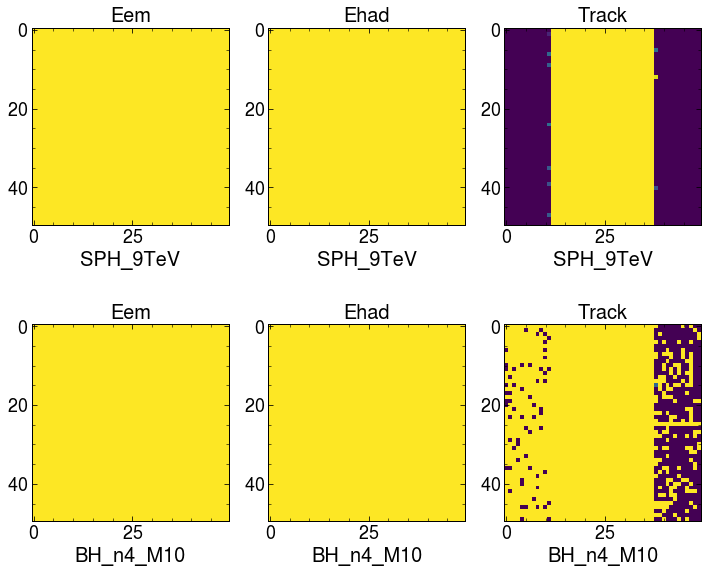

In [72]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 10))
for i in range(CLASSES):
    for j in range(3):
        axs[i][j].imshow(images[i][j], vmin=0, vmax=1)
        axs[i][j].set_xlabel(PLOT_LABELS[i])
        axs[i][j].set_title(layer_labels[j])
